<a href="https://colab.research.google.com/github/Eldave93/mlp-handover/blob/main/workshops/week-04/4_Workshop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Week 04 - Distance Workshop
by [David Elliott](#DavidElliot), with minor editing by Cassandra Khan


1. [Problem Understanding and Setup](#setup)
2. [Unsupervised Project](#UP) 
3. [Supervised Project](#SP)




# 1. Problem Understanding and Setup <a id='setup'></a>

We are going to look at the application of K-means Clustering and KNN (K-Nearest-Neighbour) Clustering to the analysis and classification of greyscale images: the numbers 0 - 9.

Questions to answer are marked with a ⭐ (star).

## 1.2. Workspace

We'll load the necessary tools and libraries:

In [ ]:
# Display plots inline
%matplotlib inline

# Data libraries
import pandas as pd
import numpy as np

# Plotting libraries
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting defaults
plt.rcParams['figure.figsize'] = (10,6)
plt.rcParams['figure.dpi'] = 80

# sklearn modules
import sklearn
import sklearn.cluster
import sklearn.manifold
import sklearn.preprocessing
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from scipy.cluster.hierarchy import dendrogram
import scipy.cluster

In [ ]:
from sklearn.datasets import load_digits
import warnings
from sklearn.metrics.pairwise import euclidean_distances, manhattan_distances, paired_distances
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
import pandas as pd

## 1.3. Data

Here is our dataset:

In [ ]:
X_digits, y_digits = load_digits(return_X_y=True, as_frame=True)

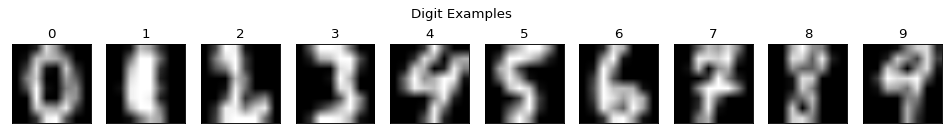

In [ ]:
# set random seed (change to see different examples)
np.random.seed(seed=42)

fig, ax = plt.subplots(1, 10, figsize=(15, 2))

# find the unique digits
unique_digits = np.unique(y_digits)

# for each unique digit...
for digit in unique_digits:
    # find the indices for different digits
    idxs = np.where(y_digits==digit)[0]
    # randomly select an index
    idx = np.random.choice(idxs)
    # plot the example image
    ax[digit].imshow(X_digits.loc[idx].values.reshape(8, 8), 
                     cmap='gray', interpolation="bilinear")
    # set the subplot title as the digit
    ax[digit].set_title(digit)
    # tidy the grid up
    ax[digit].grid(False)
    ax[digit].set_xticks([])
    ax[digit].set_yticks([])
    
plt.suptitle("Digit Examples")
plt.show()

As we can see, the images do look like their labelled numbers, although some may be harder to distinguish than others (e.g. 1 and 2).

## 1.4. Inital Look at the Data Structure

Greyscale images can be thought of as having multiple features / pixel values.

In [ ]:
X_digits

,pixel_0_0,pixel_0_1,pixel_0_2,pixel_0_3,pixel_0_4,pixel_0_5,pixel_0_6,pixel_0_7,pixel_1_0,pixel_1_1,pixel_1_2,pixel_1_3,pixel_1_4,pixel_1_5,pixel_1_6,pixel_1_7,pixel_2_0,pixel_2_1,pixel_2_2,pixel_2_3,pixel_2_4,pixel_2_5,pixel_2_6,pixel_2_7,pixel_3_0,pixel_3_1,pixel_3_2,pixel_3_3,pixel_3_4,pixel_3_5,pixel_3_6,pixel_3_7,pixel_4_0,pixel_4_1,pixel_4_2,pixel_4_3,pixel_4_4,pixel_4_5,pixel_4_6,pixel_4_7,pixel_5_0,pixel_5_1,pixel_5_2,pixel_5_3,pixel_5_4,pixel_5_5,pixel_5_6,pixel_5_7,pixel_6_0,pixel_6_1,pixel_6_2,pixel_6_3,pixel_6_4,pixel_6_5,pixel_6_6,pixel_6_7,pixel_7_0,pixel_7_1,pixel_7_2,pixel_7_3,pixel_7_4,pixel_7_5,pixel_7_6,pixel_7_7
0,0.0,0.0,5.0,13.0,9.0,1.0,0.0,0.0,0.0,0.0,13.0,15.0,10.0,15.0,5.0,0.0,0.0,3.0,15.0,2.0,0.0,11.0,8.0,0.0,0.0,4.0,12.0,0.0,0.0,8.0,8.0,0.0,0.0,5.0,8.0,0.0,0.0,9.0,8.0,0.0,0.0,4.0,11.0,0.0,1.0,12.0,7.0,0.0,0.0,2.0,14.0,5.0,10.0,12.0,0.0,0.0,0.0,0.0,6.0,13.0,10.0,0.0,0.0,0.0
1,0.0,0.0,0.0,12.0,13.0,5.0,0.0,0.0,0.0,0.0,0.0,11.0,16.0,9.0,0.0,0.0,0.0,0.0,3.0,15.0,16.0,6.0,0.0,0.0,0.0,7.0,15.0,16.0,16.0,2.0,0.0,0.0,0.0,0.0,1.0,16.0,16.0,3.0,0.0,0.0,0.0,0.0,1.0,16.0,16.0,6.0,0.0,0.0,0.0,0.0,1.0,16.0,16.0,6.0,0.0,0.0,0.0,0.0,0.0,11.0,16.0,10.0,0.0,0.0
2,0.0,0.0,0.0,4.0,15.0,12.0,0.0,0.0,0.0,0.0,3.0,16.0,15.0,14.0,0.0,0.0,0.0,0.0,8.0,13.0,8.0,16.0,0.0,0.0,0.0,0.0,1.0,6.0,15.0,11.0,0.0,0.0,0.0,1.0,8.0,13.0,15.0,1.0,0.0,0.0,0.0,9.0,16.0,16.0,5.0,0.0,0.0,0.0,0.0,3.0,13.0,16.0,16.0,11.0,5.0,0.0,0.0,0.0,0.0,3.0,11.0,16.0,9.0,0.0
3,0.0,0.0,7.0,15.0,13.0,1.0,0.0,0.0,0.0,8.0,13.0,6.0,15.0,4.0,0.0,0.0,0.0,2.0,1.0,13.0,13.0,0.0,0.0,0.0,0.0,0.0,2.0,15.0,11.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,12.0,12.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,10.0,8.0,0.0,0.0,0.0,8.0,4.0,5.0,14.0,9.0,0.0,0.0,0.0,7.0,13.0,13.0,9.0,0.0,0.0
4,0.0,0.0,0.0,1.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,8.0,0.0,0.0,0.0,0.0,0.0,1.0,13.0,6.0,2.0,2.0,0.0,0.0,0.0,7.0,15.0,0.0,9.0,8.0,0.0,0.0,5.0,16.0,10.0,0.0,16.0,6.0,0.0,0.0,4.0,15.0,16.0,13.0,16.0,1.0,0.0,0.0,0.0,0.0,3.0,15.0,10.0,0.0,0.0,0.0,0.0,0.0,2.0,16.0,4.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1792,0.0,0.0,4.0,10.0,13.0,6.0,0.0,0.0,0.0,1.0,16.0,14.0,12.0,16.0,3.0,0.0,0.0,4.0,16.0,6.0,3.0,16.0,4.0,0.0,0.0,0.0,12.0,16.0,16.0,16.0,5.0,0.0,0.0,0.0,0.0,4.0,4.0,16.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,5.0,0.0,0.0,0.0,5.0,7.0,7.0,16.0,4.0,0.0,0.0,0.0,2.0,14.0,15.0,9.0,0.0,0.0
1793,0.0,0.0,6.0,16.0,13.0,11.0,1.0,0.0,0.0,0.0,16.0,15.0,12.0,16.0,1.0,0.0,0.0,3.0,16.0,7.0,0.0,13.0,6.0,0.0,0.0,4.0,16.0,0.0,0.0,10.0,8.0,0.0,0.0,8.0,16.0,0.0,0.0,14.0,6.0,0.0,0.0,5.0,16.0,7.0,9.0,16.0,5.0,0.0,0.0,1.0,15.0,16.0,16.0,16.0,1.0,0.0,0.0,0.0,6.0,16.0,14.0,6.0,0.0,0.0
1794,0.0,0.0,1.0,11.0,15.0,1.0,0.0,0.0,0.0,0.0,13.0,16.0,8.0,2.0,1.0,0.0,0.0,0.0,16.0,15.0,10.0,16.0,5.0,0.0,0.0,0.0,8.0,16.0,16.0,7.0,0.0,0.0,0.0,0.0,9.0,16.0,16.0,4.0,0.0,0.0,0.0,0.0,16.0,14.0,16.0,15.0,0.0,0.0,0.0,0.0,15.0,15.0,15.0,16.0,0.0,0.0,0.0,0.0,2.0,9.0,13.0,6.0,0.0,0.0
1795,0.0,0.0,2.0,10.0,7.0,0.0,0.0,0.0,0.0,0.0,14.0,16.0,16.0,15.0,1.0,0.0,0.0,4.0,16.0,7.0,3.0,16.0,7.0,0.0,0.0,5.0,16.0,10.0,7.0,16.0,4.0,0.0,0.0,0.0,5.0,14.0,14.0,16.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,16.0,2.0,0.0,0.0,0.0,4.0,7.0,7.0,16.0,2.0,0.0,0.0,0.0,5.0,12.0,16.0,12.0,0.0,0.0


For any given number, you can see that most of the pixels that surround the number itself -- the pixels on the image borders -- have very little variation in their value. So it's likely that the pixel data for most of the written numbers lies in columns 2 - 5.

Also note that when we look at X_digits, we see an array with dimensions 1797 rows × 64 columns, where each of the 64 columns (aka "features") is the brightness of one pixel.

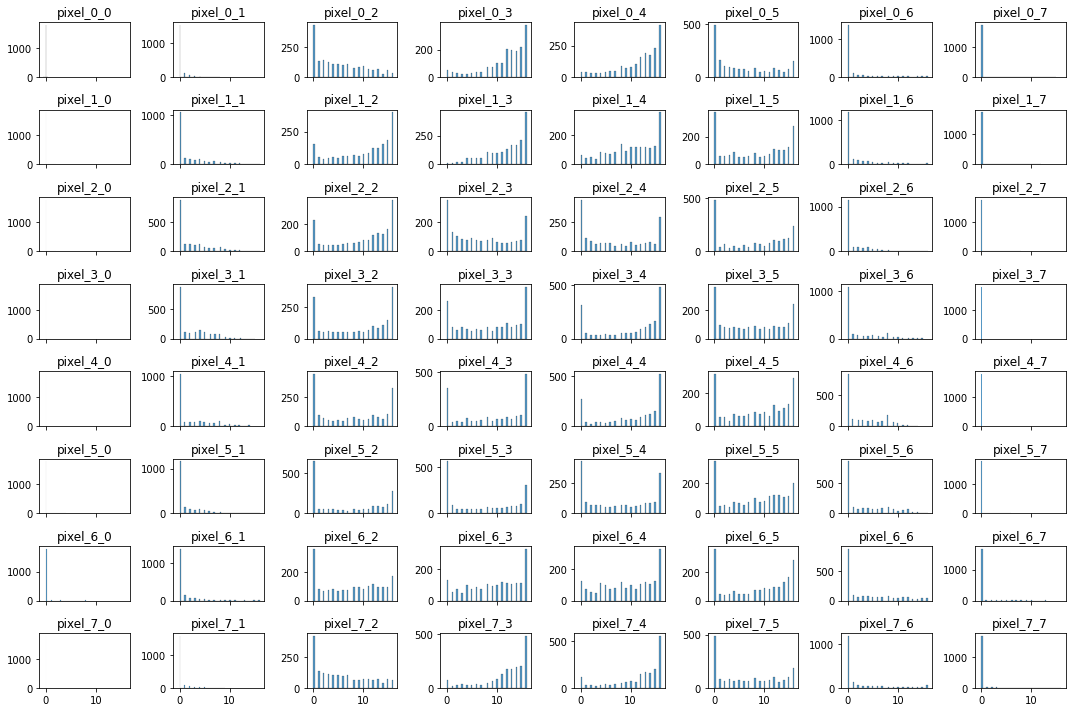

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
fig, axes = plt.subplots(figsize=(15,10), ncols=8, nrows=8, sharex=True)
axes = axes.flatten()
for i, ax in enumerate(axes):
    sns.histplot(data = X_digits.iloc[:,i], bins=50, ax=ax)
    ax.set_title(X_digits.iloc[:,i].name)
    ax.set_ylabel("")
    ax.set_xlabel("")

plt.tight_layout()
plt.show()

---

## 1.5. Creating a Test Set


For our purposes this week we are just going to scale all our data by dividing by 255 (the pixel value for absolute white). This is because large differences between the value of our data points increase our model's uncertainty. Scaling the data makes it easier for a model to learn. We are then also going to split the data into training and test splits. Having good test sets is important to get a good idea of generalisation performance. This is still true but this week, we are just going to randomly split these sets (why will become clear soon). 

In [ ]:
X_digits = X_digits / 255.0
X_train, X_test, y_train, y_test = train_test_split(X_digits.values, y_digits.values, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=42)

 Now we are going to do something you would **not** normally do, we are going to delete the labels for the training set (`y_train`).

In [ ]:
del y_train

Why would we do this? 

To study how we can use distance-based models to help understand / classify unlabelled data. 
 
So why bother keeping `y_test` and `y_val` labels? 

Because later we will look at semi-supervised and supervised learning so we can pretend that we did the labour intensive process of making test set labels ourselves (saved you some work there!)

We have a dataset with 64 features, but it would be convenient for our purposes to visualise them in two dimensions when doing cluster analysis. This is what we are going to use TSNE for this week.

<><><><><><><><><><><><>


What is TSNE? 

From  https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html  :

TSNE: T-distributed Stochastic Neighbor Embedding.

t-SNE is a tool to visualize high-dimensional data. It converts similarities between data points to joint probabilities and tries to minimize ... divergence between the joint probabilities of the low-dimensional embedding and the high-dimensional data. With different initializations of t-SNE we can get different results.

It is highly recommended to use another dimensionality reduction method (e.g. PCA for dense data or TruncatedSVD for sparse data) to reduce the number of dimensions to a reasonable amount (e.g. 50) if the number of features is very high. This will suppress some noise and speed up the computation of pairwise distances between samples.

<><><><><><><><><><><><>


For our purposes this week, its enough to know that this is a method that can capture the local structure of high-dimensional data well whist visually revealing the presence of clusters<sup>1</sup>.

We know this data data has 10 digits (0-9) and you can hopefully make out 10(ish) main clusters in the data, with some digits that are between different clusters.

1. Van der Maaten, L., & Hinton, G. (2008). Visualizing data using t-SNE. Journal of machine learning research, 9(11).

# ⭐ **Plot the clusters.**

Plotting structure for (e.g.) the x-column data using TSNE:

plt.xlim(df_tsne.min()['x'], df_tsne.max()['x'])

In [ ]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, perplexity=10., random_state=42)
data_tsne = tsne.fit_transform(X_train)
df_tsne = pd.DataFrame(data_tsne, columns=['x', 'y'])

plt.figure(figsize=(10,10))
#-v-v-v-v- Plot your clustered data for both x and y as a scatter plot. -v-v-v-v
#-v-v-v-v- Write your code here -v-v-v-v


Our aim is to cluster this data in its normal 64 dimensions, and then have a look at how well our clustering works, with the help of 2-dimensional embedding. We hope that our machine clustering will map (roughly) to the clusters we can see above.

---
## K-means

What if we didn't have the labels? What if each cluster was ***not*** linked to a unique digit?

Each column maps to a cluster and therefore, the column names are not the digits, they are the cluster number.

In [ ]:
k = 10
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(X_train)

KMeans(n_clusters=10, random_state=42)

# ⭐ **Following the previous example, plot the K-means clustered data**.

In [ ]:
#-v-v-v-v- Plot your K-means clustered data for both x and y as a scatter plot. -v-v-v-v
#-v-v-v-v- Write your code here -v-v-v-v


plt.title("K-means clustered data")
plt.show()

To consider: How does the clustering above vary with varying perplexity (say, 5 - 9) and values of k (5 - 9)? Sugestion: hold one parameter constant, and vary the other. What do these changes indicate about these two parameters?

(NB: Original values are perplexity = k = 10)

Let's have a look at the example closest to the center of each cluster to see if we can tell which cluster contains which digits.


## ⭐ **Using the data in the array *X_representative_digits*, replot the cluster data as digits.**

(Hint: choices for plt.imshow should be: reshape(8, 8), cmap='gray', interpolation="bilinear")

In [ ]:
X_digits_dist = kmeans.transform(X_train)
representative_digit_idx = np.argmin(X_digits_dist, axis=0)
X_representative_digits = X_train[representative_digit_idx]

plt.figure(figsize=(15, 2))
for index, X_representative_digit in enumerate(X_representative_digits):
    plt.subplot(k // 10, 10, index + 1)
    #-v-v-v-v- Write your code here -v-v-v-v
    
    
    plt.axis('off')

plt.show()

As we can see from the plot output, each cluster we have identified is linked to a unique digit.

Recall from the lecture ("What makes a good cluster?" pp. 9 -10), that the Sum of Squared Errors (SSE), or ***cluster inertia***, is

$SSE = \sum\limits^n_{i=1}\sum\limits^K_{k=1}w_{ik}||x_{1i}-x_{2i}||^2_{ 2}$

where *i* is the sample index, and $\mu_k$ is the centroid (representative point) for the cluster *c*. 

If sample $\textbf{x}_i$ is in the cluster *k*, then $w_{ik} = 1$; otherwise, $w_{ik} = 0$ .

More plainly, 

*Inertia is the sum of the squared distances between each training instance and its closest centroid.*

## ⭐ **Plot K-Means Inertia versus Number of Clusters (i.e., Inertia as an output, a function of the number of clusters).**

What can you say, for this dataset, about the relationship between inertia and number of clusters?

In [ ]:
distortions = []
k_list = list(range(1, 21))
for k in k_list:
     #-v-v-v-v- Fill in the values for n_clusters, random_state, and fit -v-v-v-v
    km = KMeans(n_clusters=  , random_state=  ).fit( )
    distortions.append(km.inertia_)

sns.lineplot(x=k_list,y=np.array(distortions), marker='o')
plt.axvline(10, linestyle='--')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title("K-means Inertia")
plt.show()

Write your answer here:

#Silhouette Scores and Silhouette Diagrams

Recall from the lecture that a Silhouette score is a graphical tool used to measure how tightly two grouped samples in clusters are. The Silhouette Scores is defined as the mean Silhouette Coefficient over all samples.

From https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_samples.html :

The Silhouette Coefficient is a measure of how well samples are clustered with samples that are similar to themselves. Clustering models with a high Silhouette Coefficient are said to be dense, where samples in the same cluster are ***similar to each other and well separated***, and samples compared between different clusters are not very similar to each other.

In [ ]:
import numpy as np
from matplotlib import cm
from sklearn.metrics import silhouette_samples
# adapted from https://github.com/rasbt/python-machine-learning-book-3rd-edition/blob/master/ch11/ch11.ipynb

examples = range(8,12)
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (15,6), sharex=True)

axes = axes.flatten()
for i, example in enumerate(examples):
    plt.sca(axes[i])
    km = KMeans(n_clusters=example, 
                init='k-means++', 
                n_init=10, 
                max_iter=300,
                tol=1e-04,
                random_state=0)
    y_km = km.fit_predict(X_train)

    cluster_labels = np.unique(y_km)
    n_clusters = cluster_labels.shape[0]
    silhouette_vals = silhouette_samples(X_train, y_km, metric='euclidean')
    y_ax_lower, y_ax_upper = 0, 0
    yticks = []
    for i, c in enumerate(cluster_labels):
        c_silhouette_vals = silhouette_vals[y_km == c]
        c_silhouette_vals.sort()
        y_ax_upper += len(c_silhouette_vals)
        color = cm.jet(float(i) / n_clusters)
        plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1.0, 
                 edgecolor='none', color=color)

        yticks.append((y_ax_lower + y_ax_upper) / 2.)
        y_ax_lower += len(c_silhouette_vals)

    silhouette_avg = np.mean(silhouette_vals)
    plt.axvline(silhouette_avg, color="red", linestyle="--") 

    plt.yticks(yticks, cluster_labels + 1)
    plt.ylabel('Cluster')
    plt.xlabel('Silhouette coefficient')
    plt.title("k = " + str(example))

plt.tight_layout()
plt.suptitle("K-means Silhouette Diagram")
plt.show()

## ⭐ **Looking at the graphs above, what can you say about the realtionship(s) between the Silhouette coefficient (0.0 - 0.5), the k-value, and the size and number of clusters in our data set?**

Write your answer here:

In [ ]:
import seaborn as sns
from sklearn.metrics import adjusted_rand_score

### Hierarchical Clustering

Here is code that creates a dendrogram representing Agglomerative clustering (using **Ward's linkage**) of our numerical dataset.

Recall from the lecture notes (Sectio 4, Hierarchical Clustering), that:

Agglomerative (or ***bottom-up***) clustering is the most common type of hierarchical clustering and refers to the fact that a dendrogram (generally
depicted as an upside-down tree) is built starting from the leaves and *combining* clusters up to the trunk .

Notes

Each leaf of the dendrogram represents an observation and as we move ***up*** the tree, some leaves begin to fuse into branches. These correspond to observations that are similar to each other .

As we move higher up the tree, branches themselves fuse, either with leaves or other branches.

The earlier (lower in the tree) fusions occur, the more similar the groups of observations are to each other. On the other hand, observations that fuse later (near the top of the tree) can be quite different.


**REM**: Hierarchical clustering is an approach to clustering which does not require that we commit to a fixed number of clusters. Instead we can determine the number of clusters using a tree-based representation of the observations, called a dendrogram 


### Ward's Linkage

Ward's Linkage:

- Distance between a pair of clusters is defined by how much the sum of squares will increase when those two clusters are merged.

- With hierarchical clustering, the sum of squares grows from zero (since every data point can, initially, be defined as a 'cluster'), increasing as we merge clusters. Ward’s linkage method minimizes / limits this growth.


In [ ]:
def get_labels(m):
    if hasattr(m, 'labels_'):
        return(m.labels_)
    else:
        return(m.steps[-1][1].labels_)

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram
    # from sklearn documentaion:
    # https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html
    
    # create the counts of samples under each node
    
    if (type(model) == sklearn.pipeline.Pipeline):
        model = model.steps[-1][1]
    
    counts = np.zeros(model.children_.shape[0])
    labels = get_labels(model)
    n_samples = len(labels)
    
    
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    Z = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    palette = [mpl.colors.rgb2hex(c) for c in sns.color_palette(n_colors = model.n_clusters_)]
    
    link_cols = {}
    for i, i12 in enumerate(Z[:,:2].astype(int)):
        c1, c2 = (link_cols[x] if x > len(Z) else palette[labels[x]] for x in i12)
        link_cols[i+1+len(Z)] = c1 if c1 == c2 else "#808080"
    
    # Plot the corresponding dendrogram
    dendrogram(Z, link_color_func=lambda x: link_cols[x], **kwargs)
    
    
    if (model.n_clusters_ == 1):
        threshold = np.max(model.distances_)
    elif (model.distance_threshold is None):
        i = model.n_clusters_-1
        threshold = (model.distances_[-i] + model.distances_[-(i+1)])/2
    else:
        threshold = model.distance_threshold
    
    plt.axhline(y=threshold, color="0.25", linestyle="--")

def fit_aggclust(X, n_clusters=2, distance_threshold=None, linkage='ward'):
    
    try:
        distance_threshold = float(distance_threshold)
    except:
        distance_threshold = None
    
    if (distance_threshold is not None):
        n_clusters = None
    
    # Fit model
    m = sklearn.cluster.AgglomerativeClustering(
        distance_threshold=distance_threshold, n_clusters=n_clusters, 
        linkage=linkage, compute_full_tree = True, compute_distances = True
    ).fit(X)
    
    #d['cluster'] = m.labels_
    #d['cluster'] = d['cluster'].astype('category')
    
    # Plot
    plt.figure(figsize=(12,6))
    
    plot_dendrogram(m, show_leaf_counts=False, no_labels=True)

    plt.show()
    
    return m.labels_

In [ ]:
labels_ = fit_aggclust(X_train, n_clusters=10, distance_threshold=None, linkage='ward')

## ⭐ **Using the code you wrote to plot the K-means clustered data, plot the Ward's linkage clustered data.**

In a separate text box, describe (briefly) the differences between the two plots.

In [ ]:
#-v-v-v-v- Write your code here -v-v-v-v



plt.title("Ward's linkage clustered data")
plt.show()

According to t-SNE, the clustering is a bit better with hierarchical clustering

##⭐ **Describe what you see: are there any discernable differences between the K-means and Ward's linkage scatter plots?  Why or why not?**

Write your answer here:

### Average Linkage

Here is code that creates a dendrogram representing Agglomerative clustering using average linkage of our numerical dataset.

Average Linkage:

- Uses mean intercluster dissimilarity.

- Computes all pairwise dissimilarities between the observations in cluster A and the observations in cluster B, and records the average of these dissimilarities.


In [ ]:
labels_ = fit_aggclust(X_train, n_clusters=10, distance_threshold=None, linkage='average')


## ⭐ **Using the code you wrote to plot the K-means clustered data, plot the Average-linkage clustered data.**


In [ ]:
#-v-v-v-v- Write your code here -v-v-v-v




plt.title("Average-linkage clustered data")
plt.show()

##⭐ **Compare the scatter plots for Ward's and Average linkages.** 
##What differences do you see?

Write your answer below:


## Assessing cluster performance

### Which hierarchical clustering method is optimal?

Here, we use cophenetic correlation (i.e., we calculate the cophenetic correlation coefficient, *CPC*, and the cophenetic matrix, *CP*, below) to assess how well a dendrogram preserves the pairwise distances between the original data points.

The closer a CPC is to 1, the better the dendrogram linkage represents the geometry of the associated cluster(s).

Further reading: 

*Chapter 4, Hierarchical Clustering in Action*, in *Hands-On Unsupervised Learning with Python: Implement Machine Learning and Deep Learning Models Using Scikit-Learn, TensorFlow, and More*  by Giuseppe Bonaccorso -- Available online through [DiscoverEd](https://discovered.ed.ac.uk/)

In [ ]:
from scipy.cluster.hierarchy import linkage, cophenet
from scipy.spatial.distance import pdist

dm = pdist(X_train, metric='euclidean')

cpc, cp = cophenet(linkage(dm, method='ward'), dm) 
print('CPC Ward\'s linkage: {:.3f}'.format(cpc))

cpc, cp = cophenet(linkage(dm, method='single'), dm) 
print('CPC Single linkage: {:.3f}'.format(cpc))

cpc, cp = cophenet(linkage(dm, method='complete'), dm) 
print('CPC Complete linkage: {:.3f}'.format(cpc))

cpc, cp = cophenet(linkage(dm, method='average'), dm) 
print('CPC Average linkage: {:.3f}'.format(cpc))

In [ ]:
from sklearn.metrics import calinski_harabasz_score

print("k-means")
kmeans = KMeans(n_clusters=10, random_state=42)
kmeans.fit(X_train)
display(calinski_harabasz_score(X_train, kmeans.labels_))

#print("Fuzzy c-means")
#display(calinski_harabasz_score(X_train, kmeans.labels_))

print("Agglomerative Clustering")
AC = sklearn.cluster.AgglomerativeClustering(n_clusters=10)
AC.fit(X_train)
display(calinski_harabasz_score(X_train, AC.labels_))

## ⭐ **A higher Calinski-Harabasz score relates to a model with better defined clusters.**

###Why do you think K-means seem to produce better-defined clusters, compared to Agglomerative clustering?

Write your answer here:

# 3. Semi-Supervised Learning

## Problem Understanding

Semi-supervised learning is used in the case where we have lots of unlabelled examples, and few labeled cases (common).

## Data Pre-Processing <a id='prep'></a>

We can use models that use distance-based metrics at a number of stages in our machine learning pipeline.

### Anomaly detection (or outlier detection)

> any instance that has a low affinity to all the clusters is likely to be an anomaly. For example, if you have clus‐ tered the users of your website based on their behavior, you can detect users with unusual behavior, such as an unusual number of requests per second, and so on. Anomaly detection is particularly useful in detecting defects in manufacturing, or for fraud detection.
>
> Geron (2019)

__Notes__

- In the "outlier section" we can use ellipticEnvelope and LOF
    - Detecting anomalies are introduced in Hands-On Machine Learning with scikit-learn and Scientific Python Toolkits; just using percentiles may not aleways be best, and a model-based approach may be warranted.
    - For example, ellipticEnvelope and LOF is linked to other algorithms: _"If the k-means clustering algorithm of the previous chapter falls into the same group as the elliptic envelope algorithm, then the LOF would be the counterpart of the DBSCAN algorithm"_

In [ ]:
def plot_2d_clusters(x, y, ax): 
    y_uniques = pd.Series(y).unique() 
    for y_unique_item in y_uniques:
        x[ y == y_unique_item ].plot(
            title=f'{len(y_uniques)} Clusters', 
            kind='scatter', 
            x='x', y='y',
            marker=f'${y_unique_item}$', 
            ax=ax)

Here we create our clusters using 
Density-based Spatial Clustering of Applications with Noise (DBSCAN), a density-based clustering method.

For each instance:
- The algorithm counts how many instances are located within a small distance, $\epsilon$ , of it .
- If an instance has at least min_samples instances around it, then it is considered a core instance .
- If a point has fewer neighbours than min_samples within , but lies within the of a core instance, its considered a border point.
- All points not a core point or border point are considered noise points (or anomaly) .

**Notes**

- Clusters are defined as continuous regions of high density .
- The region around each instance is called an $\epsilon$-neighbourhood .
- Core instances are instances located in dense regions .

In [ ]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.1, min_samples=5)
dbscan.fit(X_train)
display(np.unique(dbscan.labels_))

fig, axs = plt.subplots(1, figsize=(10,10))
plt.xlim(df_tsne.min()['x'], df_tsne.max()['x'])
plt.ylim(df_tsne.min()['y'], df_tsne.max()['y'])
plot_2d_clusters(df_tsne, dbscan.labels_, ax=axs)
plt.show()

## ⭐ **Note that the number of recognised clusters is very sensitive to $\epsilon$ [~ 0.08 → 0.17]. How does changing $\epsilon$ change the number of recognised clusters, and why? (You can also change the parameter *min_samples*  to see if you can increase the limits on $\epsilon$)**

Write your answer here:

### Data Cleaning 

- Here we employ the "Nearest neighbors imputation" (KNNImputer): https://scikit-learn.org/stable/modules/impute.html

In [ ]:
from sklearn.impute import KNNImputer

# set some data to na and then show how it uses the KNN method to fill it in.

### Dimensionality Reduction

> Once a dataset has been clustered, it is usually possible to measure each instance’s affinity with each cluster (affinity is any measure of how well an instance fits into a cluster). Each instance’s feature vector x can then be replaced with the vector of its cluster affinities. If there are k clusters, then this vector is k dimensional. This is typically much lower dimensional than the original feature vector, but it can preserve enough information for further processing.
>
> Geron (2019)

In [ ]:
k = 10
kmeans = KMeans(n_clusters=k, random_state=42)
X_digits_dist = kmeans.fit_transform(X_train)
pd.DataFrame(X_digits_dist)

## Model Exploration <a id='explore'></a>

## Supervised Learning

- Label some of the instances at random.
- train a KNN model on those labels and test on our (pre-labeled) test set .
- K-nearest neighbors (KNN) is a **supervised** classification algorithm which uses labelled data to train on.

- Given a small amount of labelled data points, KNN can classify new, unlabelled data points by analysis of the **k number** of the nearest data points. The variable ***k*** is a parameter (chosen by the programmer) that represents the number of nearest neighbours to include to classify / label the new data point.


In [ ]:
import random
random.seed(42)
k = 50
X_rand_digits = random.choices(X_train, k=k)

plt.figure(figsize=(8, 2))
for index, X_rand_digit in enumerate(X_rand_digits):
    plt.subplot(k // 10, 10, index + 1)
    plt.imshow(X_rand_digit.reshape(8, 8), cmap="binary", interpolation="bilinear")
    plt.axis('off')

plt.show()

In [ ]:
y_rand_digits = np.array([
    5, 8, 1, 6, 5, 9, 3, 9, 1, 7,
    0, 6, 5, 9, 9, 3, 6, 9, 2, 0,
    8, 0, 7, 5, 6, 6, 5, 0, 8, 4,
    8, 7, 9, 8, 7, 9, 9, 0, 6, 1,
    2, 8, 2, 8, 2, 3, 6, 8, 9, 8
])

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

KNN = KNeighborsClassifier()
KNN.fit(X_rand_digits, y_rand_digits)
score = KNN.score(X_val, y_val)
print("KNN 50 Labels Accuracy: %.2f"%round(score*100,2)+"%")

## Semi-Supervised Learning
- We can use the clusters in a semi-supervised labeling method (get the centroids) and get better results.

> if you only have a few labels, you could perform clustering and propagate the labels to all the instances in the same cluster. This can greatly increase the amount of labels available for a subsequent supervised learning algorithm, and thus improve its performance.
>
> Geron (2019)

In [ ]:
k = 50
kmeans = KMeans(n_clusters=k, random_state=42)
X_digits_dist = kmeans.fit_transform(X_train)
representative_digit_idx = np.argmin(X_digits_dist, axis=0)
X_representative_digits = X_train[representative_digit_idx]

plt.figure(figsize=(8, 2))
for index, X_representative_digit in enumerate(X_representative_digits):
    plt.subplot(k // 10, 10, index + 1)
    plt.imshow(X_representative_digit.reshape(8, 8), cmap="binary", interpolation="bilinear")
    plt.axis('off')

plt.show()

In [ ]:
from sklearn.linear_model import LogisticRegression

y_representative_digits = np.array([
    8, 3, 4, 0, 7, 1, 5, 2, 5, 7,
    5, 4, 4, 6, 9, 3, 7, 8, 1, 3,
    2, 1, 6, 2, 0, 7, 8, 9, 9, 9,
    6, 2, 4, 5, 3, 8, 1, 3, 7, 8,
    7, 6, 4, 8, 1, 9, 1, 5, 4, 0
])
#NB: Previously, we had KNN.fit(X_rand_digits, y_rand_digits)
KNN = KNeighborsClassifier()
KNN.fit(X_representative_digits, y_representative_digits)
score = KNN.score(X_val, y_val)
print("KNN 50 Labels Accuracy: %.2f"%round(score*100,2)+"%")

## ⭐ **Explain the jump in accuracy from 64.09% to 83.09%.**


Write your answer here:

__Active Learning__<sup>2</sup>

To continue improving this model above is we could use active learning, where human experts provide labels for specific instances when requested by the algorithm.

A strategy for this is _uncertainty sampling_:
    
1. A model trains using labeled instances and makes predictions on unlabelled instance
2. The instances where the model is the most uncertain (e.g. using probabilities), is given an expert label.
3. You iterate the above process until performance improvement stops being worth the labelling effort.

Other strategies include:
- Labeling instances that will result in the most model change,
- Result in the largest drop in validation error,
- Instances where different models (e.g. SVM or Random Forest) disagree the most.

## Supervised Learning...again

- Finally provide all the labels and do a proper model tuning.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_digits.values, y_digits.values, random_state=42)

In [ ]:
from sklearn.model_selection import cross_validate

KNN = KNeighborsClassifier()
KNN.fit(X_train, y_train)

# tidy the output into a dataframe
def tidy_scores(score_dict):
    df = pd.DataFrame(score_dict)
    df.loc['mean'] = df.mean()
    df.loc['sd'] = df.std()
    df.rename({"test_score":"val_score"}, axis=1, inplace=True)
    df.index.name = "fold"
    return df.round(2)

scores = cross_validate(KNN, X_train, y_train, cv=5, return_train_score=True)
tidy_scores(scores)

In [ ]:
#When using the K-nearest neighbors algorithm it is important to Standard Scale the data
#REM: Scaling is important for distance-based classification measures
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn import set_config
set_config(display='diagram')

knn_pipe = Pipeline([
    ("dim_reduce", KMeans(n_clusters=50, random_state=42)),
    ("model", KNeighborsClassifier())
])

scores = cross_validate(knn_pipe, X_train, y_train, cv=5, return_train_score=True)
tidy_scores(scores)

## ⭐ **Note that the scores we see in the first table are created by the code:**

*scores = cross_validate(KNN, X_train, y_train, cv=5, return_train_score=True)*

## **and the scores in the second table are created by the code:**

*scores = cross_validate(knn_pipe, X_train, y_train, cv=5, return_train_score=True)*

## **Explain the difference between *KNN* and *knn_pipe*. How does setting up a pipeline change the output from the first to the second table?**

References: Look at 

[Scikit Pipeline: chaining estimators](https://scikit-learn.org/stable/modules/compose.html#pipeline)

[sklearn.pipeline.Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html)  

Write your answer here: